# Image inpainting with the use of neural networks

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import Image
import sys
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

In [110]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA runtime:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

CUDA available: True
CUDA runtime: 12.1


device(type='cuda')

## PipeDataset and DataLoader pipelineline

In [97]:
import kagglehub

path = kagglehub.dataset_download("dimensi0n/lhq-1024")
# path = os.path.join(path, "dataset")
print("Path to dataset files:", path)


Path to dataset files: C:\Users\mikid\.cache\kagglehub\datasets\dimensi0n\lhq-1024\versions\1


In [98]:
transform_256 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=path, transform=transform_256)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

def create_random_mask(image_size=(256, 256), min_size=32, max_size=64):
    h, w = image_size
    mask = torch.zeros(1, h, w)
    
    rect_h = random.randint(min_size, max_size)
    rect_w = random.randint(min_size, max_size)
    
    top = random.randint(0, h - rect_h)
    left = random.randint(0, w - rect_w)
    
    mask[:, top:top+rect_h, left:left+rect_w] = 1
    
    return mask

class InpaintingDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, image_size=(256, 256)):
        self.base_dataset = base_dataset
        self.image_size = image_size
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        mask = create_random_mask(self.image_size)
        
        masked_image = image * (1 - mask)
        
        return masked_image, mask, image 

train_inpainting = InpaintingDataset(train_dataset)
val_inpainting = InpaintingDataset(val_dataset)
test_inpainting = InpaintingDataset(test_dataset)

train_dataloader = DataLoader(train_inpainting, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_inpainting, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_inpainting, batch_size=8, shuffle=False)

## Dataset sample visualization

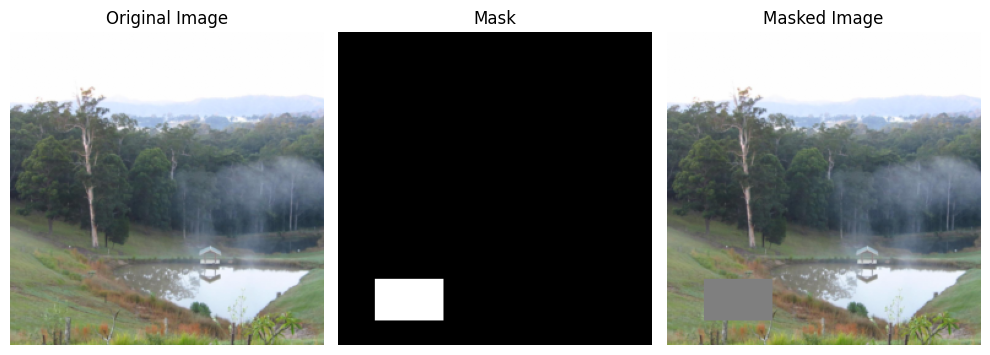

In [ ]:
masked_image, mask, original_image = train_inpainting[0]

def unnormalize(img):
    return img * 0.5 + 0.5

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(unnormalize(original_image).permute(1, 2, 0)) 
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(),cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(unnormalize(masked_image).permute(1, 2, 0))
plt.title('Masked Image')
plt.axis('off')

plt.tight_layout()
plt.show()

## Model Architecture

In [100]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)


class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        
        return x * psi


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.up(x)


class AttentionUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, features=[64, 128, 256, 512]):
        super(AttentionUNet, self).__init__()
        
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attention_gates = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.downs.append(ConvBlock(in_channels, feature))
            in_channels = feature
        
        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)
        
        for feature in reversed(features):
            self.ups.append(UpConv(feature * 2, feature))
            self.attention_gates.append(AttentionGate(F_g=feature, F_l=feature, F_int=feature // 2))
            self.ups.append(ConvBlock(feature * 2, feature))
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.tanh = nn.Tanh()
    
    def forward(self, masked_image, mask):
        x = torch.cat([masked_image, mask], dim=1)
        
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)  
            skip_connection = skip_connections[idx // 2]
            
            attention_idx = idx // 2
            skip_connection = self.attention_gates[attention_idx](g=x, x=skip_connection)
            
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)
            
            x = torch.cat([skip_connection, x], dim=1)
            x = self.ups[idx + 1](x) 
        
        output = self.final_conv(x)
        output = self.tanh(output)  
        
        return output

## Loss function implementation

In [101]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layers=[3, 8, 15, 22]):
        super().__init__()
        
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features
        
        for param in self.features.parameters():
            param.requires_grad = False
        
        self.layers = layers
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))
    
    def normalize(self, x):
        return ((x + 1.0) / 2.0 - self.mean) / self.std
    
    def forward(self, pred, target, mask=None):
        pred, target = self.normalize(pred), self.normalize(target)
        
        loss = 0.0
        for i, layer in enumerate(self.features):
            pred, target = layer(pred), layer(target)
            if i in self.layers:
                if mask is not None:
                    mask_resized = nn.functional.interpolate(mask, size=pred.shape[2:], mode='nearest')
                    loss += torch.mean(((pred - target) * mask_resized) ** 2)
                else:
                    loss += nn.functional.mse_loss(pred, target)
        
        return loss


class InpaintingLoss(nn.Module):
    def __init__(self, l1_weight=1.0, perceptual_weight=0.1):
        super().__init__()
        self.l1_weight = l1_weight
        self.perceptual_weight = perceptual_weight
        self.perceptual_loss = VGGPerceptualLoss()
    
    def forward(self, pred, target, mask):
        l1 = (nn.functional.l1_loss(pred, target, reduction='none') * (mask * 9.0 + 1.0)).mean()
        
        perceptual = self.perceptual_loss(pred, target, mask) if self.perceptual_weight > 0 else 0
        
        return {
            'l1': l1,
            'perceptual': perceptual if isinstance(perceptual, torch.Tensor) else torch.tensor(0.0, device=pred.device),
            'total': self.l1_weight * l1 + self.perceptual_weight * (perceptual if isinstance(perceptual, torch.Tensor) else 0)
        }

## Training pipeline

In [ ]:
def calculate_psnr(pred, target, mask=None, max_val=1.0):
    with torch.no_grad():
        if mask is not None:
            pred, target = pred * mask, target * mask
        mse = torch.mean((pred - target) ** 2)
        return float('inf') if mse == 0 else (20 * torch.log10(max_val / torch.sqrt(mse))).item()


def run_epoch(model, dataloader, criterion, device, epoch, optimizer=None):
    model.train() if optimizer else model.eval()
    epoch_losses = {'total': 0, 'l1': 0, 'perceptual': 0}
    epoch_psnr = 0
    
    mode = 'Train' if optimizer else 'Val'
    pbar = tqdm(dataloader, desc=f'Epoch {epoch} [{mode}]')
    
    with torch.set_grad_enabled(optimizer is not None):
        for masked_image, mask, target in pbar:
            masked_image, mask, target = masked_image.to(device), mask.to(device), target.to(device)
            
            if optimizer:
                optimizer.zero_grad()
            
            output = model(masked_image, mask)
            losses = criterion(output, target, mask)
            
            if optimizer:
                losses['total'].backward()
                optimizer.step()
            
            for key in epoch_losses:
                epoch_losses[key] += losses[key].item()
            
            psnr = calculate_psnr(output, target, mask, max_val=2.0)
            epoch_psnr += psnr
            
            pbar.set_postfix({'loss': losses['total'].item(), 'psnr': psnr})
    
    num_batches = len(dataloader)
    return {k: v/num_batches for k, v in epoch_losses.items()}, epoch_psnr/num_batches


def visualize_results(model, dataloader, device, save_path, num_samples=4):
    model.eval()
    masked_image, mask, target = next(iter(dataloader))
    
    with torch.no_grad():
        output = model(masked_image[:num_samples].to(device), mask[:num_samples].to(device))
    
    denorm = lambda x: (x + 1) / 2
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    for i in range(num_samples):
        for j, (img, title, cmap) in enumerate([
            (masked_image[i], 'Masked Input', None),
            (mask[i, 0], 'Mask', 'gray'),
            (output[i].cpu(), 'Inpainted', None),
            (target[i], 'Ground Truth', None)
        ]):
            if cmap:
                axes[i, j].imshow(img.cpu() if img.is_cuda else img, cmap=cmap)
            else:
                axes[i, j].imshow(denorm(img.cpu() if img.is_cuda else img).permute(1, 2, 0).clamp(0, 1))
            axes[i, j].set_title(title)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.close()


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs, save_dir='models'):
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True)
    
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_psnr': [], 'val_psnr': []}
    
    for epoch in range(1, num_epochs + 1):
        print(f"\n{'='*60}\nEpoch {epoch}/{num_epochs}\n{'='*60}")
        
        train_losses, train_psnr = run_epoch(model, train_loader, criterion, device, epoch, optimizer)
        val_losses, val_psnr = run_epoch(model, val_loader, criterion, device, epoch)
        
        scheduler.step(val_losses['total'])
        
        for key in ['train_loss', 'val_loss', 'train_psnr', 'val_psnr']:
            history[key].append(train_losses['total'] if 'train' in key and 'loss' in key else
                               val_losses['total'] if 'val' in key and 'loss' in key else
                               train_psnr if 'train' in key else val_psnr)
        
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            torch.save({
                'epoch': epoch, 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_loss': val_losses['total'], 'val_psnr': val_psnr,
            }, save_dir / 'best_model.pth')
            print(f"✓ Saved best model (val_loss: {val_losses['total']:.4f})")
        
        if epoch % 5 == 0:
            torch.save({
                'epoch': epoch, 'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
            }, save_dir / f'checkpoint_epoch_{epoch}.pth')
            visualize_results(model, val_loader, device, save_dir / f'results_epoch_{epoch}.png')
    
    return history


torch.cuda.empty_cache()

model = AttentionUNet(
    in_channels=4, 
    out_channels=3,
    features=[32, 64, 128, 256] 
).to(device)

criterion = InpaintingLoss(l1_weight=1.0, perceptual_weight=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


def run_epoch(model, loader, criterion, device, optimizer=None):
    model.train() if optimizer else model.eval()
    total_loss = 0
    
    with torch.set_grad_enabled(optimizer is not None):
        for masked_img, mask, target in tqdm(loader, leave=False):
            masked_img, mask, target = masked_img.to(device), mask.to(device), target.to(device)
            
            if optimizer:
                optimizer.zero_grad()
            
            output = model(masked_img, mask)
            losses = criterion(output, target, mask)
            
            if optimizer:
                losses['total'].backward()
                optimizer.step()
            
            total_loss += losses['total'].item()
            
            if optimizer:
                torch.cuda.empty_cache()
    
    return total_loss / len(loader)


def visualize(model, loader, device, n=4):
    model.eval()
    masked_img, mask, target = next(iter(loader))
    with torch.no_grad():
        output = model(masked_img[:n].to(device), mask[:n].to(device))
    
    fig, axes = plt.subplots(n, 4, figsize=(16, n*4))
    for i in range(n):
        for j, (img, title, cmap) in enumerate([
            (masked_img[i], 'Input', None),
            (mask[i,0], 'Mask', 'gray'),
            (output[i], 'Output', None),
            (target[i], 'Target', None)
        ]):
            if cmap:
                axes[i,j].imshow(img.cpu(), cmap=cmap)
            else:
                axes[i,j].imshow(((img.cpu()+1)/2).permute(1,2,0).clamp(0,1))
            axes[i,j].set_title(title)
            axes[i,j].axis('off')
    plt.tight_layout()
    plt.savefig('visualization.png', dpi=150, bbox_inches='tight')
    plt.show()
save_dir = Path('models')

In [105]:
# num_epochs = 10
# model.load_state_dict(torch.load(save_dir / 'best_model.pth'))
# best_loss = 0.08654

# for epoch in range(1, num_epochs + 1):
#     train_loss = run_epoch(model, train_dataloader, criterion, device, optimizer)
#     val_loss = run_epoch(model, val_dataloader, criterion, device)
#     scheduler.step(val_loss)
    
#     print(f"Epoch {epoch} | Train: {train_loss:.5f} | Val: {val_loss:.5f}")
    
#     if val_loss < best_loss:
#         best_loss = val_loss
#         torch.save(model.state_dict(), save_dir / 'best_model.pth')

## Model evaluation

C:\Users\mikid\AppData\Local\Temp\ipykernel_10848\1052797656.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_dir / 'best_model.pth'

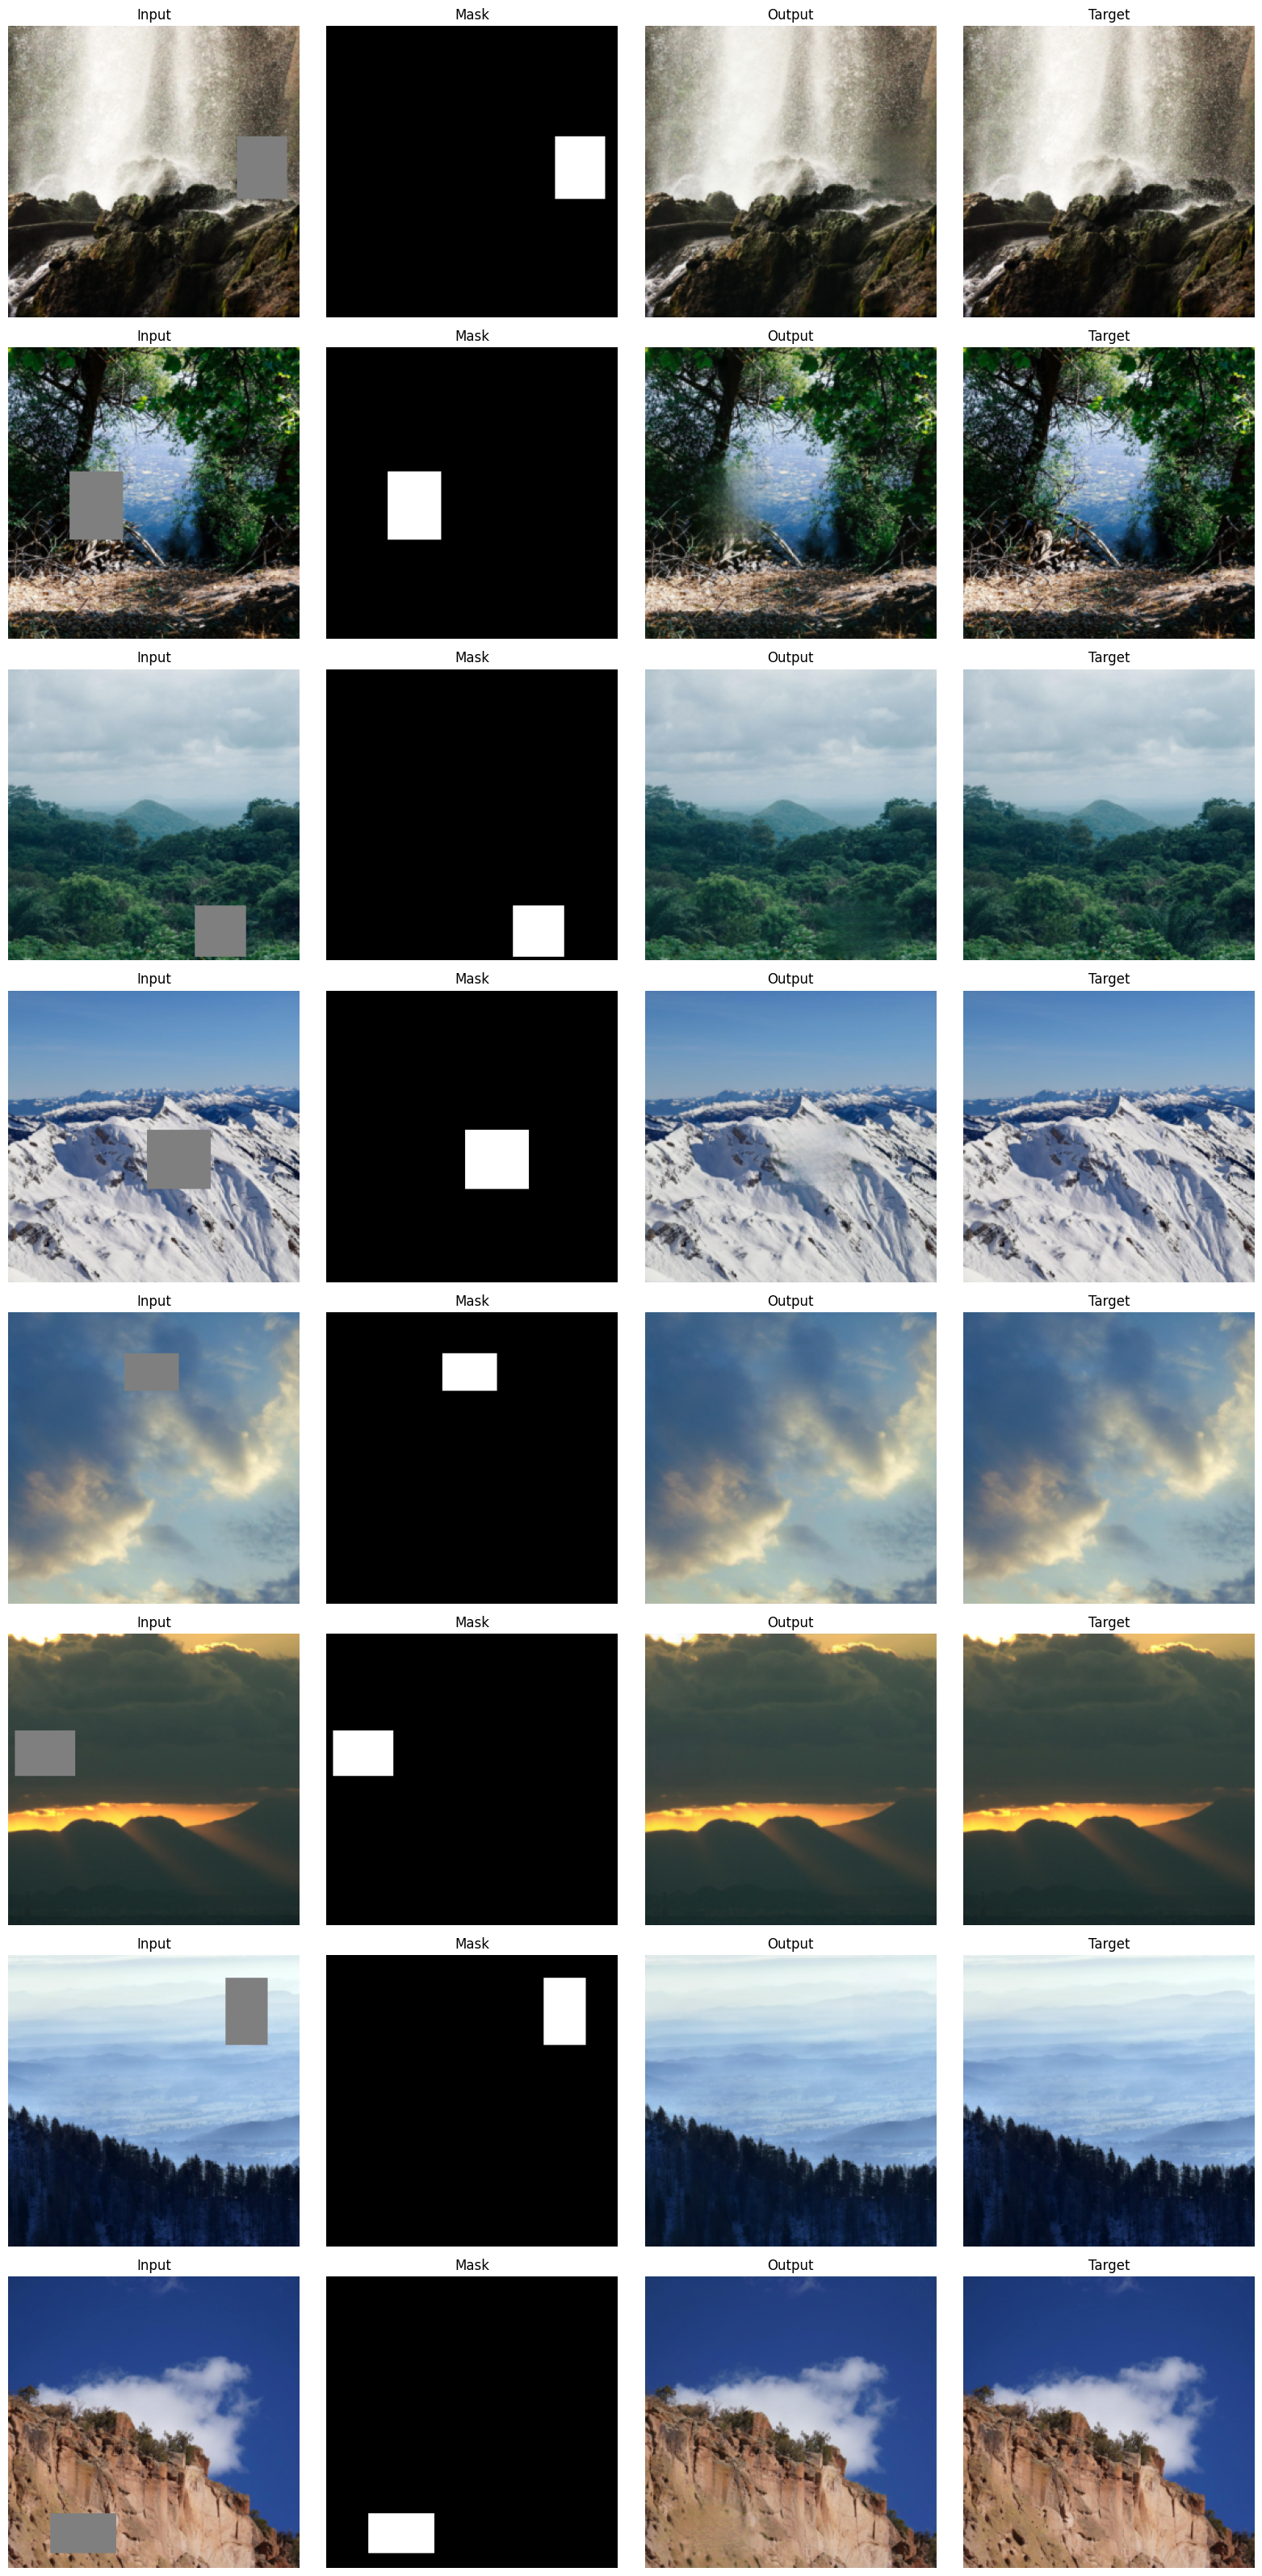

In [106]:
model.load_state_dict(torch.load(save_dir / 'best_model.pth'))
visualize(model, test_dataloader, device, n=8)

## Model deployment pipeline with a Flask inference server

In [111]:
from flask import Flask, render_template, request, jsonify
from PIL import Image
import io
import base64

with open('templates/index.html', 'r') as f:
    html_content = f.read()

app = Flask(__name__)

model = AttentionUNet(in_channels=4, out_channels=3, features=[32, 64, 128, 256]).to(device)
model.load_state_dict(torch.load(save_dir / 'best_model.pth', weights_only=False))
model.eval()

infer_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def process_image(image, mask_coords=None):
    img_tensor = infer_transform(image).unsqueeze(0).to(device)
    
    mask = torch.zeros(1, 1, 256, 256).to(device)
    if mask_coords:
        x, y, w, h = mask_coords
        mask[:, :, y:y+h, x:x+w] = 1
    else:
        mask[:, :, 96:160, 96:160] = 1
    
    masked_img = img_tensor * (1 - mask)
    
    with torch.no_grad():
        output = model(masked_img, mask)
    
    output = ((output.cpu().squeeze() + 1) / 2).clamp(0, 1)
    output = output.permute(1, 2, 0).numpy()
    output = (output * 255).astype('uint8')
    
    return Image.fromarray(output)

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/inpaint', methods=['POST'])
def inpaint():
    try:
        if 'image' not in request.files:
            return jsonify({'error': 'No image uploaded'}), 400
        
        file = request.files['image']
        
        if file.filename == '':
            return jsonify({'error': 'No file selected'}), 400
        
        file_bytes = file.read()
        image = Image.open(io.BytesIO(file_bytes)).convert('RGB')
        
        image = image.resize((256, 256), Image.Resampling.LANCZOS)
        
        mask_coords = None
        if 'mask' in request.form:
            import json
            mask_data = json.loads(request.form['mask'])
            mask_coords = [
                int(mask_data['x']), 
                int(mask_data['y']), 
                int(mask_data['width']), 
                int(mask_data['height'])
            ]
        
        result = process_image(image, mask_coords)
        
        buffered = io.BytesIO()
        result.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        return jsonify({'result': f'data:image/png;base64,{img_str}'})
    
    except Exception as e:
        print(f"Error: {str(e)}")
        return jsonify({'error': str(e)}), 500

os.makedirs('templates', exist_ok=True)



with open('templates/index.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("http://localhost:5000")

app.run(debug=False, port=5000, use_reloader=False)

http://localhost:5000
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
